In [1]:
!pip install langgraph langchain-google-genai pydantic langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.3 MB/s eta 0:00:00


In [6]:
from langgraph.graph import StateGraph , START  , END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict , Annotated , Literal
from pydantic import BaseModel , Field
import operator
from langchain_core.messages import BaseMessage , SystemMessage, HumanMessage

In [7]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [8]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
    , api_key= api_key)

In [9]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
  messages : Annotated[list[BaseMessage] , add_messages]


In [61]:
def chat_node(state : ChatState):
  # take user query from state
  #print(state['messages'])
  query = state['messages']
  #print("---------------------------------")

  # send to llm
  response = model.invoke(query)
  #print(response)
  # response store state

  #print(state['messages'] )
  return {'messages':[response]}


In [62]:
graph = StateGraph(ChatState)

# nodes
graph.add_node('chat_node' , chat_node)

#Add edges
graph.add_edge(START , 'chat_node')
graph.add_edge('chat_node' , END)

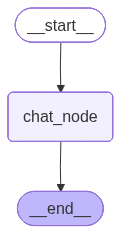

In [63]:
graph.compile()

In [64]:
workflow = graph.compile()

In [67]:
while True:
  user_query = input("Enter your query : ")

  if user_query.strip().lower() in ['exit' , 'bye' , 'end' , 'ok bye' ] :
    break

  initial_state = {'messages' :  [
        SystemMessage(content="You are a helpful assistant.Always answer in less than 50 words "),
        HumanMessage(content=user_query)
    ]}
  response = workflow.invoke(initial_state);

  print(f"You asked : {response['messages'][1].content} \nBot Reply : {response['messages'][2].content}")



Enter your query : ok bye


### problem no memory !
chatbot is being reinvoked everytime with the while loop intereation so new invoke --> new state --> memory fkd everthing cleared


Solution --> persistance ---> at the end node of graph dont erase state ... store it somewhere

1. Add checkpointer and pass to compile()
2. add thread config and pass to invoke()


Uses RAM , use database in production

In [79]:
from langgraph.checkpoint.memory import MemorySaver

In [80]:
checkpointer = MemorySaver()
persisted_graph = StateGraph(ChatState)

# nodes
persisted_graph.add_node('chat_node' , chat_node)

#Add edges
persisted_graph.add_edge(START , 'chat_node')
persisted_graph.add_edge('chat_node' , END)

In [83]:
workflow = persisted_graph.compile(checkpointer = checkpointer)

In [85]:
thread_id ="1"
while True:
  user_query = input("Enter your query : ")

  if user_query.strip().lower() in ['exit' , 'bye' , 'end' , 'ok bye' ] :
    break

  initial_state = {'messages' :  [
        SystemMessage(content="You are a helpful assistant. Always answer in less than 50 words "),
        HumanMessage(content=user_query)
    ]}

  config = {'configurable' :{'thread_id' : thread_id} }

  response = workflow.invoke(initial_state , config=config);

  print(f"You asked : {response['messages'][-2].content} \nBot : {response['messages'][-1].content}")



Enter your query : hi i am shagun
You asked : hi i am shagun 
Bot : Hi Shagun! It's good to hear from you again. How can I help you today?
Enter your query : i am sad todaay 
You asked : i am sad todaay  
Bot : I'm sorry to hear you're feeling sad today, Shagun. Is there anything I can do to help, or something you'd like to talk about?
Enter your query : what was my name 


ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 29.191846459s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '29s'}]}}

In [86]:
workflow.get_state(config=config)

StateSnapshot(values={'messages': [SystemMessage(content='You are a helpful assistant. Always answer in less than 50 words ', additional_kwargs={}, response_metadata={}, id='0c175ce7-f56e-49b9-a867-939161cc9213'), HumanMessage(content='hi i am shagun', additional_kwargs={}, response_metadata={}, id='937ba7e7-d039-4ec6-9236-105d884a25c5'), AIMessage(content='Hi Shagun! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c7a01-117e-7683-8963-fcea02eb7724-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 22, 'output_tokens': 40, 'total_tokens': 62, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 24}}), SystemMessage(content='You are a helpful assistant. Always answer in less than 50 words ', additional_kwargs={}, response_metadata={}, id='d2fb61e2-6144-45eb-876e-4185b64a